In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from utils import *

In [13]:
# Set Pandas option to display all columns
pd.set_option('display.max_columns', None)

In [14]:
#df = pd.read_csv("../data/modified_small.csv")
df = pd.read_csv("../data/modified_small_imputed.csv")


df_long = expand_to_long_format(df)

In [15]:
df_long.head()

,n_cycles_trying,outcome_pregnant,age_group,bmi_group,been_pregnant_before_binary,average_cycle_length_group,regular_cycle,university_education,regular_sleep,intercourse_frequency_group,dedication_group,cycle,event_this_cycle
0,1,1,30-35,normal,False,21-35,True,True,True,high,medium,1,1
1,7,1,30-35,normal,True,21-35,True,True,True,medium,low,1,0
1,7,1,30-35,normal,True,21-35,True,True,True,medium,low,2,0
1,7,1,30-35,normal,True,21-35,True,True,True,medium,low,3,0
1,7,1,30-35,normal,True,21-35,True,True,True,medium,low,4,0


In [16]:
df_long["cycle_cat"] = pd.cut(
    df_long["cycle"],
    bins=[0, 3, 6, 9, 12, np.inf],
    labels=["1-3", "4-6", "7-9", "10-12", "13+"]
)

In [17]:
df_long["cycle_cat"]

0       1-3
1       1-3
1       1-3
1       1-3
1       4-6
       ... 
1992    13+
1992    13+
1993    1-3
1994    1-3
1994    1-3
Name: cycle_cat, Length: 9428, dtype: category
Categories (5, object): ['1-3' < '4-6' < '7-9' < '10-12' < '13+']

In [18]:
# Define input variables

numerical_vars = [
    #"cycle",
]


categorical_vars = {
    'age_group':'30-35',
    'bmi_group':'normal',
    'been_pregnant_before_binary':False,
    'average_cycle_length_group':'21-35',
    'regular_cycle':True,
    'university_education':False,
    'regular_sleep':True,
    'intercourse_frequency_group':'medium',
    'dedication_group':'medium',
    'cycle_cat': '1-3'
}


X = prepare_model_matrix(
    df=df_long.drop(columns=['event_this_cycle', 'outcome_pregnant', 'n_cycles_trying']),
    categorical_baselines=categorical_vars,
    center_numeric=numerical_vars
)
y = df_long["event_this_cycle"]

X = X.astype({col: 'int' for col in X.select_dtypes(bool).columns})


# Drop missing values
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask]
y = y[mask]

In [19]:
X.columns

Index(['age_group_35-44', 'age_group_19-29', 'bmi_group_overweight',
       'bmi_group_underweight', 'been_pregnant_before_binary_True',
       'average_cycle_length_group_<21 OR >35', 'regular_cycle_False',
       'university_education_True', 'regular_sleep_False',
       'intercourse_frequency_group_high', 'intercourse_frequency_group_low',
       'dedication_group_low', 'dedication_group_high', 'cycle_cat_4-6',
       'cycle_cat_7-9', 'cycle_cat_10-12', 'cycle_cat_13+'],
      dtype='object')

In [20]:
# STEP 4: Fit logistic regression model
X = sm.add_constant(X)

In [21]:
X

,const,age_group_35-44,age_group_19-29,bmi_group_overweight,bmi_group_underweight,been_pregnant_before_binary_True,average_cycle_length_group_<21 OR >35,regular_cycle_False,university_education_True,regular_sleep_False,intercourse_frequency_group_high,intercourse_frequency_group_low,dedication_group_low,dedication_group_high,cycle_cat_4-6,cycle_cat_7-9,cycle_cat_10-12,cycle_cat_13+
0,1.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,1.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,1.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,1.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,1.0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1992,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1993,1.0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0
1994,1.0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [22]:
print("Final design matrix shape:", X.shape)
print("Final outcome vector shape:", y.shape)
print(X.dtypes)

Final design matrix shape: (9428, 18)
Final outcome vector shape: (9428,)
const                                    float64
age_group_35-44                            int64
age_group_19-29                            int64
bmi_group_overweight                       int64
bmi_group_underweight                      int64
been_pregnant_before_binary_True           int64
average_cycle_length_group_<21 OR >35      int64
regular_cycle_False                        int64
university_education_True                  int64
regular_sleep_False                        int64
intercourse_frequency_group_high           int64
intercourse_frequency_group_low            int64
dedication_group_low                       int64
dedication_group_high                      int64
cycle_cat_4-6                              int64
cycle_cat_7-9                              int64
cycle_cat_10-12                            int64
cycle_cat_13+                              int64
dtype: object


In [23]:

model = sm.Logit(y, X) # discrete-time proportional odds model
result = model.fit()

# STEP 5: Summarize results
summary = result.summary2().tables[1]
summary["Odds Ratio"] = np.exp(summary["Coef."])
summary["CI Lower"] = np.exp(summary["Coef."] - 1.96 * summary["Std.Err."])
summary["CI Upper"] = np.exp(summary["Coef."] + 1.96 * summary["Std.Err."])

# Display final table
#print(summary[["Coef.", "Std.Err.", "P>|z|", "Odds Ratio", "CI Lower", "CI Upper"]])

Optimization terminated successfully.
         Current function value: 0.337291
         Iterations 9


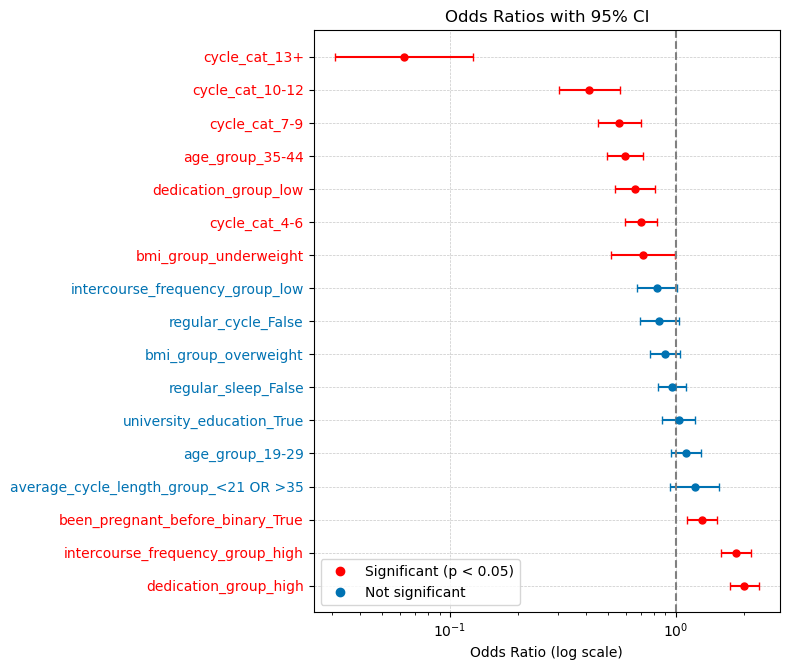

In [24]:
plot_odds_ratios(result, log_scale=True, show_cycle=True)

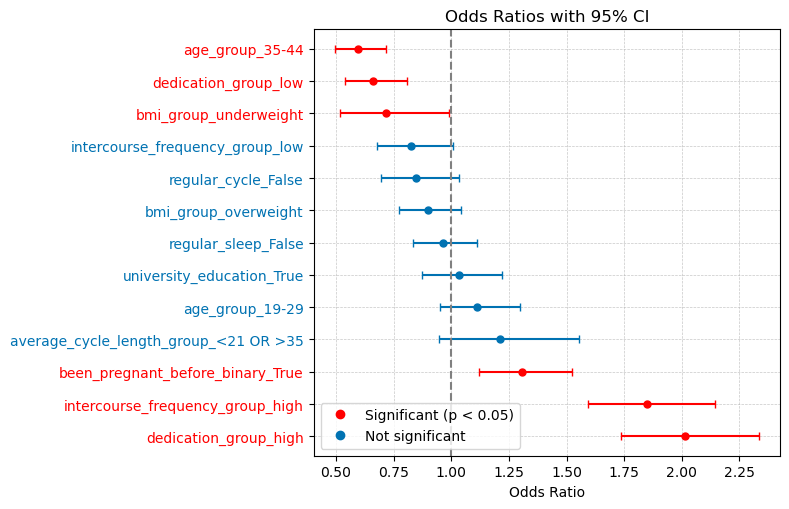

In [25]:
plot_odds_ratios(result, log_scale=False)

In [ ]:
def interpret_or(odds_ratio, baseline_prob, n_cycles=13):
    """
    Interpret an odds ratio in terms of:
    - Adjusted per-cycle probability
    - Probability of pregnancy within n cycles
    - Median time to pregnancy

    Parameters:
        odds_ratio (float): OR from discrete-time model
        baseline_prob (float): baseline per-cycle probability
        n_cycles (int): number of cycles to compute cumulative probability

    Returns:
        dict with adjusted values
    """
    # Convert OR to adjusted probability
    p0 = baseline_prob
    or_ = odds_ratio
    p1 = (or_ * p0) / (1 - p0 + or_ * p0)

    # Probability of pregnancy within n cycles
    cumulative_prob = 1 - (1 - p1) ** n_cycles

    # Median number of cycles to pregnancy
    if p1 == 1.0:
        median_ttp = 1
    else:
        median_ttp = np.log(0.5) / np.log(1 - p1)

    return {
        "adjusted_per_cycle_probability": p1,
        "cumulative_probability_within_n_cycles": cumulative_prob,
        "median_time_to_pregnancy": median_ttp
    }

In [26]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       event_this_cycle   No. Observations:                 9428
Model:                          Logit   Df Residuals:                     9410
Method:                           MLE   Df Model:                           17
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:                 0.08945
Time:                        10:59:20   Log-Likelihood:                -3180.0
converged:                       True   LL-Null:                       -3492.4
Covariance Type:            nonrobust   LLR p-value:                7.914e-122
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.8581      0.108    -17.212      0.000      -2.070      -1.646
age_group_35-44                          -0.5180      0.095     -5.445      0.000      -0.704      -0.332
age_group_19-29                           0.1045      0.079      1.315      0.189      -0.051       0.260
bmi_group_overweight                     -0.1088      0.076     -1.435      0.151      -0.257       0.040
bmi_group_underweight                    -0.3352      0.165     -2.034      0.042      -0.658      -0.012
been_pregnant_before_binary_True          0.2677      0.079      3.408      0.001       0.114       0.422
average_cycle_length_group_<21 OR >35     0.1929      0.126      1.527      0.127      -0.055       0.440
regular_cycle_False                      -0.1665      0.101     -1.648      0.099      -0.364       0.031
university_education_True                 0.0321      0.086      0.374      0.708      -0.136       0.200
regular_sleep_False                      -0.0365      0.073     -0.500      0.617      -0.180       0.107
intercourse_frequency_group_high          0.6138      0.076      8.063      0.000       0.465       0.763
intercourse_frequency_group_low          -0.1907      0.102     -1.870      0.062      -0.391       0.009
dedication_group_low                     -0.4178      0.103     -4.052      0.000      -0.620      -0.216
dedication_group_high                     0.7000      0.075      9.305      0.000       0.553       0.847
cycle_cat_4-6                            -0.3540      0.082     -4.310      0.000      -0.515      -0.193
cycle_cat_7-9                            -0.5750      0.113     -5.069      0.000      -0.797      -0.353
cycle_cat_10-12                          -0.8840      0.159     -5.572      0.000      -1.195      -0.573
cycle_cat_13+                            -2.7726      0.359     -7.718      0.000      -3.477      -2.068
=========================================================================================================
"""